In [27]:
import mysql.connector
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
conn = mysql.connector.connect(host='localhost',database='my_db',user='my_db_user')

In [29]:
cur = conn.cursor()

In [30]:
APPLICATIONS_TABLE = 'applications'
CONTRACTS_TABLE = 'contracts'
PAYMENTS_TABLE = 'payments'
DEFAULTS_TABLE = 'defaults'

## 1.a

In [31]:
contracts_df = pd.read_sql_query("SELECT * FROM %s" % CONTRACTS_TABLE, conn, index_col='contract_number')
clients_df = pd.read_sql_query("SELECT * FROM %s" % APPLICATIONS_TABLE, conn)
defaults_df = pd.read_sql_query("SELECT * FROM %s" % DEFAULTS_TABLE, conn)

In [32]:
payments_df = pd.read_sql_query("SELECT * FROM %s" % PAYMENTS_TABLE, conn, index_col='id')

In [33]:
payments_df['overdue_days'] = -1  # Ставим -1, там, где не было просрочки (потом уберем), а 0 будем ставить там, где должен был быть платеж, но не произошёл

In [34]:
for contract in payments_df.contract_number.unique():
    temp_df = payments_df[payments_df.contract_number == contract].sort_values(['date'])
    # Получаем массив индексов, т.к. индексация в "частях" pandas.DataFrame остаётся как и в исходном
    index_arr = temp_df.index.tolist()
    for i in range(1, len(index_arr)):  # Берем индексы с 1, т.к. в 0 всегда просрочка 0 (первый платеж)
        prev_ind = index_arr[i - 1]
        ind = index_arr[i]
        if payments_df.loc[ind, 'amnt_paid'] < payments_df.loc[ind, 'amnt_due']:  # Платеж не поступил или был меньше
            if payments_df.loc[prev_ind, 'overdue_days'] == -1:  # Не было просрочки
                payments_df.loc[ind, 'overdue_days'] = 0  # С текущей даты пошла просрочка, но пока что 0
            else:
#                 new_ov_days = (payments_df.loc[ind, 'date'] - payments_df.loc[prev_ind, 'date']).days  # Вычисляем кол-во дней просрочки
                #  Для простоты будем просто добавлять 30, т.к. платежи ровно через 1 мес.
                new_ov_days = 30
                payments_df.loc[ind, 'overdue_days'] = payments_df.loc[prev_ind, 'overdue_days'] + new_ov_days  # Складываем прошлую просрочку с текущей
        elif payments_df.loc[ind, 'amnt_paid'] > payments_df.loc[ind, 'amnt_due']:
            months_covered = int(round(payments_df.loc[ind, 'amnt_paid'] / payments_df.loc[ind, 'amnt_due'], 0))  # Считаем, за сколько месяцев оплатил
            months_covered = months_covered - 1  # Вычитаем 1 месяца из погашения, т.к. мы не прибавили 30 дней за текущий месяц
            # Вычитаем из просрочки количество "погашенных" просроченных платежей
            # В случае более сложного начисления (с процентами, неравномерные платежи) надо использовать логику сложнее
            payments_df.loc[ind, 'overdue_days'] = payments_df.loc[prev_ind, 'overdue_days'] - months_covered * 30
            if payments_df.loc[ind, 'overdue_days'] < 0:
                payments_df.loc[ind, 'overdue_days'] = -1  # Если погасил весь долг - нет просрочки

In [35]:
# Берем макс. дату выхода в просрочку 90+, т.к. вдруг клиент гасил просрочку 90 и возрашался в 60
default_dates = payments_df[payments_df.overdue_days == 90].groupby(['contract_number'], as_index=False).agg({"date": "max"})

In [36]:
# Определяем дату договора и заёмщика
payments_df['contract_date'] = np.nan
payments_df['id_number'] = 0
for ind in payments_df.index:
    row = payments_df.loc[ind]
    payments_df.loc[ind, 'contract_date'] = contracts_df.loc[row.contract_number].contract_date
    payments_df.loc[ind, 'id_number'] = contracts_df.loc[row.contract_number].id_number

In [37]:
# Определяем "возраст" договора в месяцах на каждую дату
payments_df['age'] = 0
for contract in payments_df.contract_number.unique():
    temp_df = payments_df[payments_df.contract_number == contract].sort_values(['date'])
    index_arr = temp_df.index.tolist()
    contract_date = temp_df.contract_date.iloc[0]  # Берем первую дату договора из таблицы, т.к. они все одинаковые
    for i in range(0, len(index_arr)):
        ind = index_arr[i]
        curr_date = payments_df.loc[ind, 'date']
        curr_age = (curr_date.year - contract_date.year) * 12 + (curr_date.month - contract_date.month)
        payments_df.loc[ind, 'age'] = curr_age
# Такой алгоритм вычисления возраста не подойдёт для данных, у которых частота чаще, чем 1 раз в месяц

In [38]:
period_months = 12

In [39]:
out_df = payments_df[payments_df.age == period_months][['contract_number', 
                                                        'date', 
                                                        'contract_date', 
                                                        'id_number', 
                                                        'age']].reset_index(drop=True)  # Берем только нужные поля и "сбрасываем" индекс (начинаем с 0)

In [40]:
out_df['Default?'] = False

In [41]:
for contract in out_df.contract_number.unique():
    if contract in default_dates.contract_number.values:
        default_date = default_dates[default_dates.contract_number == contract].date.iloc[0]
        current_date = out_df.loc[out_df.contract_number == contract, "date"].iloc[0]
        if current_date >= default_date:
            out_df.loc[(out_df.contract_number == contract), "Default?"] = True

In [42]:
print(out_df.groupby(['id_number']).agg({"age": "max", "Default?": "max"}).rename({"age": "Age (months)"}, axis=1))

           Age (months)  Default?
id_number                        
100003               12     False
100004               12     False
100006               12     False
100007               12     False
100008               12     False
100009               12     False
100010               12     False
100011               12     False
100012               12     False
100014               12     False
100015               12     False
100016               12     False
100017               12     False
100018               12     False
100019               12     False
100020               12     False
100021               12     False
100022               12     False
100023               12     False
100025               12     False
100026               12     False
100027               12     False
100030               12     False
100031               12     False
100032               12     False
100033               12     False
100034               12     False
100035        

## 1.b

In [43]:
def get_client_score(client):
    def get_age_score(age):
        if 18 <= age < 25:
            return 10
        elif 25 <= age < 35:
            return 20
        elif 35 <= age < 45:
            return 25
        elif 45 <= age < 55:
            return 30
        else:
            return 18
        
    def get_family_score(family):
        family_score_dict = {
            1: 5,
            2: 10,
            3: 15,
            4: 10
        }
        return family_score_dict.get(family, 5)
    
    def get_income_score(income):
        if income < 30000:
            return 3
        elif 30000 <= income < 50000:
            return 5
        elif 50000 <= income < 100000:
            return 10
        elif 100000 <= income < 200000:
            return 15
        elif 200000 <= income < 350000:
            return 20
        elif 350000 <= income < 500000:
            return 25
        else:
            return 30
    
    def get_house_ownership_score(house_ownership):
        if house_ownership:
            return 20
        else:
            return 0
        
    def get_age_of_car_score(age_of_car):
        if age_of_car < 1:
            return 20
        elif 1 <= age_of_car < 3:
            return 15
        elif 3 <= age_of_car < 6:
            return 10
        elif 6 <= age_of_car < 10:
            return 5
        else:
            return 3
        
    def get_employed_by_score(employed_by):
        employed_by_score_dict = {
            3: 20,
            9: 20,
            2: 15,
            17: 5,
            19: 5,
            22: 5,
            23: 5,
            12: 5,
            7: 5,
            6: 0,
            27: 0
        }
        return employed_by_score_dict.get(employed_by, 10)
    
    def get_education_score(education):
        education_score_dict = {
            1: 15,
            2: 5,
            3: 10,
            4: 0
        }
        return education_score_dict.get(education, 0)
    
    def get_marital_status_score(marital_status):
        marital_status_score_dict = {
            1: 10,
            2: 6,
            3: 9,
            4: 7,
            5: 8,
            6: 0
        }
        return marital_status_score_dict.get(marital_status, 0)
    
    def get_position_score(position):
        position_score_dict = {
            1: 12,
            3: 12,
            4: 12,
            12: 4,
            13: 0
        }
        return position_score_dict.get(position, 6)
    
    def get_income_type_score(income_type):
        income_type_score_dict = {
            1: 10,
            2: 8,
            3: 20,
            4: 5,
            5: 0
        }
        return income_type_score_dict.get(income_type, 0)
    
    def get_housing_score(housing):
        housing_score_dict = {
            1: 15,
            2: 12,
            3: 5,
            4: 8,
            5: 0
        }
        return housing_score_dict.get(housing, 0)
    
    def get_income_score_weight(income_score):
        if income_score < 20:
            return 0.75
        else: 
            return 0.6946
            
        
    scores_weights = {
        'age': 0.6946,
        'family': 0.3473,
        'house_ownership': 0.4631,
        'age_of_car': 0.4631,
        'employed_by': 0.4631,
        'education': 0.3473,
        'marital_status': 0.2315,
        'position': 0.2778,
        'income_type': 0.4631,
        'housing': 0.3473
    }
    
    age = (datetime.date.today() - client.birth_date).days // 365
    score_dict = dict()
    score_dict['age'] = get_age_score(age) * scores_weights['age']
    score_dict['family'] = get_family_score(client.family) * scores_weights['family']
    score_dict['income'] = get_income_score(client.income) * get_income_score_weight(get_income_score(client.income))
    score_dict['house_ownership'] = get_house_ownership_score(client.house_ownership) * scores_weights['house_ownership']
    score_dict['age_of_car'] = get_age_of_car_score(client.age_of_car) * scores_weights['age_of_car']
    score_dict['employed_by'] = get_employed_by_score(client.employed_by_id) * scores_weights['employed_by']
    score_dict['education'] = get_education_score(client.education_id) * scores_weights['education']
    score_dict['marital_status'] = get_marital_status_score(client.marital_status_id) * scores_weights['marital_status']
    score_dict['position'] = get_position_score(client.position_id) * scores_weights['position']
    score_dict['income_type'] = get_income_type_score(client.income_type_id) * scores_weights['income_type']
    score_dict['housing'] = get_housing_score(client.housing_id) * scores_weights['housing']
    return score_dict

In [44]:
def get_age_category(age):
    if 18 <= age < 25:
        return '[18, 25)'
    elif 25 <= age < 35:
        return '[25, 35)'
    elif 35 <= age < 45:
        return '[35, 45)'
    elif 45 <= age < 55:
        return '[45, 55)'
    elif age != age:
        return 'None'
    else:
        return '[55, inf)'

def get_income_category(income):
    if income < 30000:
        return '[0-30000)'
    elif 30000 <= income < 50000:
        return '[30000, 50000)'
    elif 50000 <= income < 100000:
        return '[50000, 100000)'
    elif 100000 <= income < 200000:
        return '[100000, 200000)'
    elif 200000 <= income < 350000:
        return '[200000, 350000)'
    elif 350000 <= income < 500000:
        return '[350000, 500000)'
    elif income != income:
        return 'None'
    else:
        return '[500000, inf)'

def get_age_of_car_category(age_of_car):
    if age_of_car < 1:
        return '[0, 1)'
    elif 1 <= age_of_car < 3:
        return '[1, 3)'
    elif 3 <= age_of_car < 6:
        return '[3, 6)'
    elif 6 <= age_of_car < 10:
        return '[6, 10)'
    elif age_of_car != age_of_car:
        return 'None'
    else:
        return '[10, inf)'

In [45]:
clients_df['default'] = clients_df.id_number.apply(lambda x: x in defaults_df.id_number.unique())

## 1.c

In [46]:
clients_df['score'] = clients_df.apply(lambda x: sum(get_client_score(x).values()), axis=1)

In [47]:
print(clients_df)

    id_number    name  birth_date application_date  gender  children  family  \
0      100003  CGGCCG  1968-07-22       2014-06-16       1       NaN     2.0   
1      100004  AAACTC  1964-11-10       2017-01-02       0       NaN     1.0   
2      100006  TATAAG  1964-08-29       2016-09-10       1       NaN     2.0   
3      100007  AGAATA  1963-02-09       2017-09-05       0       NaN     1.0   
4      100008  ATCGGC  1968-10-27       2015-03-16       0       NaN     2.0   
5      100009  AGACGT  1978-02-05       2015-10-27       1       1.0     3.0   
6      100010  TCTGGG  1965-10-11       2017-05-21       0       NaN     2.0   
7      100011  CTTGCT  1960-06-26       2015-07-07       1       NaN     2.0   
8      100012  TTGTGG  1978-02-28       2017-10-10       0       NaN     1.0   
9      100014  GGGCGG  1987-10-26       2015-09-26       1       1.0     3.0   
10     100015  GATTCC  1961-04-22       2017-03-16       1       NaN     2.0   
11     100016  TTGCTA  1978-09-18       

In [48]:
clients_df['event'] = clients_df.default.astype(int)
clients_df['non_event'] = 1 - clients_df.default

In [49]:
clients_df['age_category'] = clients_df.birth_date.apply(lambda x: get_age_category((datetime.date.today() - x).days // 365))
clients_df['income_category'] = clients_df.income.apply(get_income_category)
clients_df['age_of_car_category'] = clients_df.age_of_car.apply(get_age_of_car_category)

In [50]:
chosen_columns = [
    'age_category',
    'income_category',
    'age_of_car_category',
]

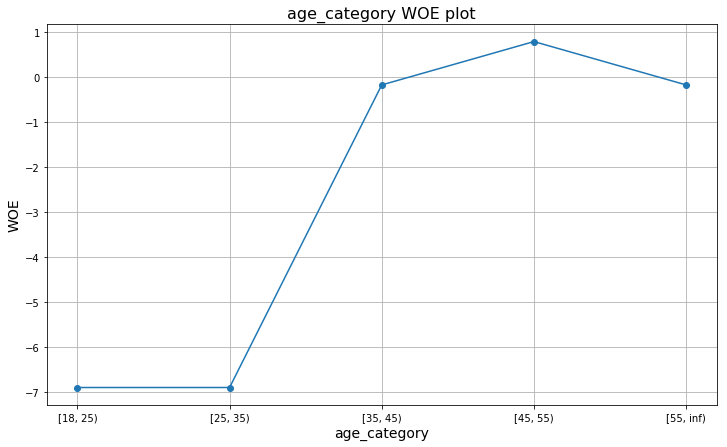

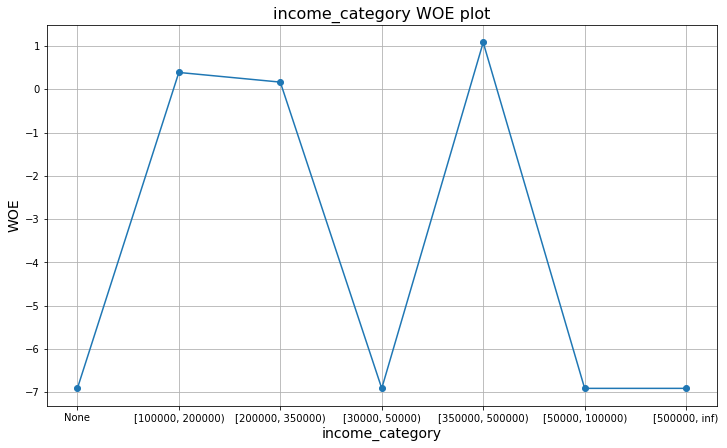

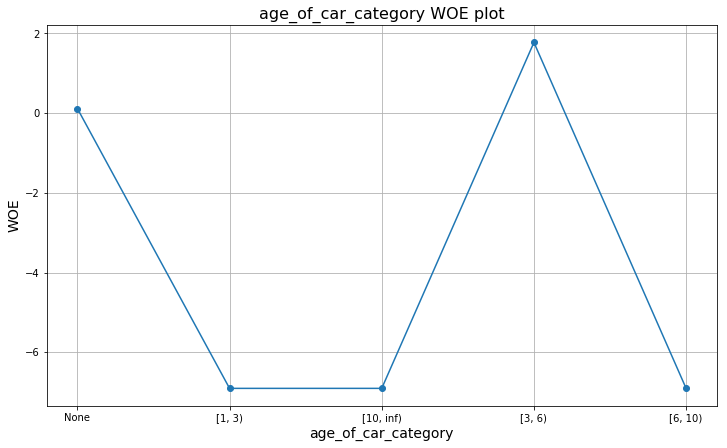

In [51]:
for column_name in chosen_columns:
    df_gb = clients_df.groupby([column_name]).agg({"default": "sum", 
                                                   "event": lambda x: x.sum() / clients_df.event.sum(), 
                                                   "non_event": lambda x: x.sum() / clients_df.non_event.sum()})
    df_gb['woe'] = np.log(np.clip(df_gb.event / df_gb.non_event, 0.001, np.inf))
    df_gb.index = df_gb.index.astype(str)
    plt.figure(figsize=(12, 7));
    plt.plot(list(range(df_gb.shape[0])), df_gb.woe, 'o-')
    plt.grid()
    plt.xticks(list(range(df_gb.shape[0])), df_gb.index)
    plt.ylabel("WOE", fontsize=14)
    plt.xlabel(column_name, fontsize=14)
    plt.title("%s WOE plot" % column_name, fontsize=16)
    plt.show()